# Классификация текстов с использованием Наивного Байесовского Классификатора

In [146]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_auc_score)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

import optuna
import warnings
warnings.filterwarnings('ignore')


## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [147]:
# откройте данные: ваш код здесь
data = pd.read_csv('data/spam_or_not_spam.csv')
mail_data = data
mail_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [148]:
# рассчитайте частоты для классов : ваш код здесь
label_counts = mail_data['label'].value_counts()
print("Частоты классов:")
print(label_counts)
print("\nПроцентное соотношение:")
print(mail_data['label'].value_counts(normalize=True) * 100)

Частоты классов:
label
0    2500
1     500
Name: count, dtype: int64

Процентное соотношение:
label
0    83.333333
1    16.666667
Name: proportion, dtype: float64


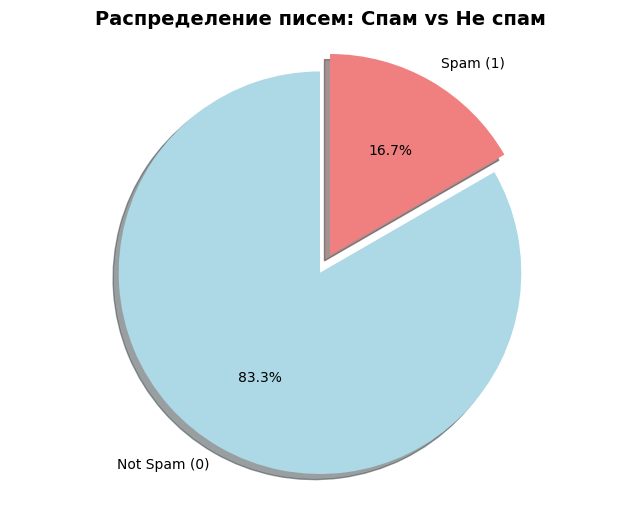

Всего писем: 3000
Не спам (0): 2500 писем (83.3%)
Спам (1): 500 писем (16.7%)


In [149]:
# визуализируйте результат: ваш код здесь

# Создаем pie chart
plt.figure(figsize=(8, 6))
labels = ['Not Spam (0)', 'Spam (1)']
colors = ['lightblue', 'lightcoral']
explode = (0.05, 0.05)  # немного разделяем сектора

plt.pie(label_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode, shadow=True)

plt.title('Распределение писем: Спам vs Не спам', fontsize=14, fontweight='bold')
plt.axis('equal')  # чтобы pie chart был круглым
plt.show()

# Дополнительная информация
print(f"Всего писем: {len(mail_data)}")
print(f"Не спам (0): {label_counts[0]} писем ({label_counts[0]/len(mail_data)*100:.1f}%)")
print(f"Спам (1): {label_counts[1]} писем ({label_counts[1]/len(mail_data)*100:.1f}%)")

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль: 
> **from sklearn.feature_extraction.text import CountVectorizer**

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [150]:
#ваш код здесь

# Заменяем пустые строки и строки из пробелов на NaN
mail_data['email'] = mail_data['email'].replace(r'^\s*$', np.nan, regex=True)
print(f"Количество пропусков в 'email': {mail_data['email'].isna().sum()}")
print(f"Количество строк до удаления: {len(mail_data)}")

# Удаляем строки с пропущенными значениями
mail_data = mail_data.dropna()
print(f"Количество строк после удаления: {len(mail_data)}")

Количество пропусков в 'email': 3
Количество строк до удаления: 3000
Количество строк после удаления: 2997


Переводим данные в векторный вид:

In [151]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(mail_data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [152]:
#ваш код здесь
print(f"Количество признаков после векторизации: {X.shape[1]}")
print(f"Размер матрицы признаков: {X.shape}")
print(f"Тип данных: {type(X)}")

Количество признаков после векторизации: 34116
Размер матрицы признаков: (2997, 34116)
Тип данных: <class 'scipy.sparse._csr.csr_matrix'>


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [153]:
#ваш код здесь
y = mail_data['label'].reset_index(drop=True)  # сбрасываем индекс для соответствия с X

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [154]:
#ваш код здесь

# Разделяем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [155]:
#ваш код здесь

# Рассчитываем среднее значение целевой переменной по тестовой выборке
mean_target_test = y_test.mean()
print(f"Среднее значение целевой переменной в тестовой выборке: {mean_target_test:.4f}")

Среднее значение целевой переменной в тестовой выборке: 0.1653


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [156]:
#ваш код здесь

# Создаем модель Multinomial Naive Bayes с параметром alpha = 0.01
# MultinomialNB подходит для текстовых данных с дискретными признаками
nb_model = MultinomialNB(alpha=0.01)

# Обучаем модель
nb_model.fit(X_train, y_train)

# Делаем предсказания
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [157]:
#ваш код здесь

# 1. Точность (Precision)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"\n1. ТОЧНОСТЬ КЛАССИФИКАЦИИ (Precision):")
print(f"   Обучающая выборка: {train_precision:.4f}")
print(f"   Тестовая выборка:   {test_precision:.4f}")

# 2. Полнота (Recall)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"\n2. ПОЛНОТА (Recall):")
print(f"   Обучающая выборка: {train_recall:.4f}")
print(f"   Тестовая выборка:   {test_recall:.4f}")

# 3. F1-метрика
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\n3. F1-МЕТРИКА:")
print(f"   Обучающая выборка: {train_f1:.4f}")
print(f"   Тестовая выборка:   {test_f1:.4f}")

# 4. ROC-AUC
train_auc = roc_auc_score(y_train, nb_model.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])
print(f"\n4. ROC-AUC:")
print(f"   Обучающая выборка: {train_auc:.4f}")
print(f"   Тестовая выборка:   {test_auc:.4f}")



1. ТОЧНОСТЬ КЛАССИФИКАЦИИ (Precision):
   Обучающая выборка: 1.0000
   Тестовая выборка:   1.0000

2. ПОЛНОТА (Recall):
   Обучающая выборка: 0.9946
   Тестовая выборка:   0.9194

3. F1-МЕТРИКА:
   Обучающая выборка: 0.9973
   Тестовая выборка:   0.9580

4. ROC-AUC:
   Обучающая выборка: 1.0000
   Тестовая выборка:   0.9951


Нарисуйте ROC-кривую:

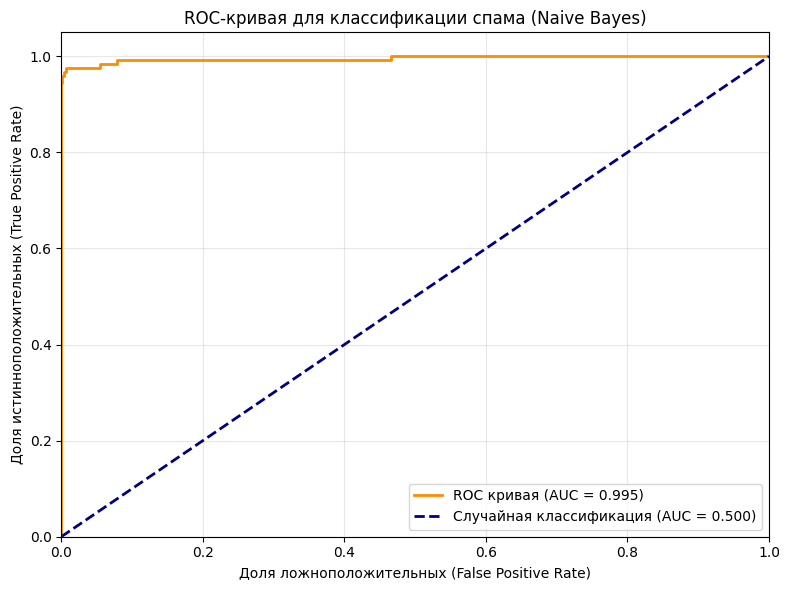

ROC AUC Score: 0.9951


In [158]:
#ваш код здесь

# Получаем вероятности для анализа
y_test_proba = nb_model.predict_proba(X_test)
# Получаем вероятности для положительного класса (спам)
y_test_scores = y_test_proba[:, 1]

# Вычисляем ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)

# Строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайная классификация (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Доля ложноположительных (False Positive Rate)')
plt.ylabel('Доля истинноположительных (True Positive Rate)')
plt.title('ROC-кривая для классификации спама (Naive Bayes)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.


Результаты оптимизации:
Лучший alpha: 0.117081
Лучший CV score: 0.9924


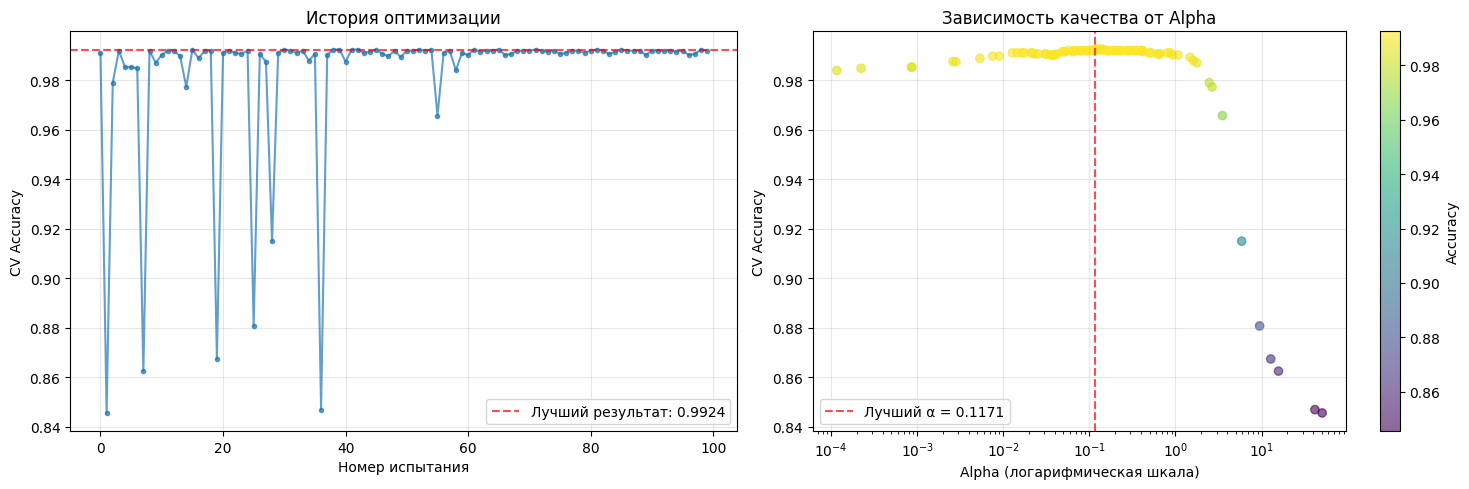

In [159]:
#ваш код здесь

# Настройки для кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ОПТИМИЗАЦИЯ ПАРАМЕТРА ALPHA С ПОМОЩЬЮ OPTUNA

# Определяем функцию цели для Optuna
def objective(trial):
    # Предлагаем значение alpha в логарифмическом масштабе
    alpha = trial.suggest_float('alpha', 1e-4, 100.0, log=True)
    # Создаем модель с предложенным alpha
    nb_model = MultinomialNB(alpha=alpha)
    # Вычисляем CV score
    cv_scores = cross_val_score(nb_model, X_train, y_train, cv=cv, scoring='accuracy')
    return cv_scores.mean()

# Подавляем вывод Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Создаем исследование Optuna
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Запускаем оптимизацию (без прогресс-бара и вывода)
study.optimize(objective, n_trials=100, show_progress_bar=False)

# Получаем результаты
best_alpha = study.best_params['alpha']
best_score = study.best_value

print(f"\nРезультаты оптимизации:")
print(f"Лучший alpha: {best_alpha:.6f}")
print(f"Лучший CV score: {best_score:.4f}")


# Анализ конвергенции
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График 1: История оптимизации
trials_values = [trial.value for trial in study.trials if trial.value is not None]
ax1.plot(trials_values, marker='o', markersize=3, alpha=0.7)
ax1.axhline(y=best_score, color='red', linestyle='--', alpha=0.7, label=f'Лучший результат: {best_score:.4f}')
ax1.set_xlabel('Номер испытания')
ax1.set_ylabel('CV Accuracy')
ax1.set_title('История оптимизации')
ax1.grid(True, alpha=0.3)
ax1.legend()

# График 2: Распределение испытанных значений alpha
alphas = [trial.params['alpha'] for trial in study.trials if trial.value is not None]
values = [trial.value for trial in study.trials if trial.value is not None]

scatter = ax2.scatter(alphas, values, alpha=0.6, c=values, cmap='viridis')
ax2.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, label=f'Лучший α = {best_alpha:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (логарифмическая шкала)')
ax2.set_ylabel('CV Accuracy')
ax2.set_title('Зависимость качества от Alpha')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.colorbar(scatter, ax=ax2, label='Accuracy')

plt.tight_layout()
plt.show()


> рекомендованное значение alpha = 0.1171